## **Aplicação de Random Forest Regression**
Neste notebook será aplicado o modelo Random Forest Regression utilizando as features extraídas dos dados .
Para avaliação do desempenho do modelo, serão utilizadas as métricas **MAE**, **MSE**, **RMSE** e **R²**, comparados aos modelos benchmark **SARIMA**, **ETS** e **Regressão Linear**. 

In [9]:
# confirgurando diretório
import sys
import os
sys.path.append(os.path.abspath('..'))

# importando bibliotecas
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from feature_engine.creation import CyclicalFeatures 
from src.outliers import detect_outliers
from src.features import (
    add_calendar_features, 
    add_lagged_features, 
    add_trend
)
from src.evaluation import Evaluation
from src.plots import plot_metrics, plot_time_series

# configurando notebook
tqdm.pandas()
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# configuração de estilo
sns.set_theme(context='paper')
plt.rcParams["figure.dpi"] = 150

%load_ext autoreload
%autoreload 2

EVAL_PATH = 'data/evaluation.csv'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## **Leitura dos Dados**

In [2]:
# leitura dos dados
train_df = pd.read_csv("data/train_df.csv", parse_dates=['ds'])
test_df = pd.read_csv("data/test_df.csv", parse_dates=['ds'])

In [3]:
features_train_df = (
    train_df.groupby("unique_id")
    .apply(lambda x: add_calendar_features(df=x))
).reset_index(drop=True)


features_test_df = (
    test_df.groupby("unique_id")
    .apply(lambda x: add_calendar_features(df=x))
).reset_index(drop=True)

# outliers
features_train_df = detect_outliers(features_train_df)
features_test_df.loc[:, ['max_outliers', 'min_outliers']] = 0

In [4]:
features_train_df.columns

Index(['unique_id', 'ds', 'y', 'day', 'month_end', 'feriado', 'day_of_week',
       'week', 'month', 'quarter', 'max_outliers', 'min_outliers'],
      dtype='object')

In [5]:
# inserindo os lags nos dados de treino e teste
kwargs = {
    'features' : ['feriado', 'month_end'],
    'lags' : [-3, -2, -1, 1, 2, 3]
}

features_train_df = (
    features_train_df.groupby("unique_id")
    .apply(lambda x: add_lagged_features(df=x, **kwargs))
).reset_index(drop=True)

features_test_df = (
    features_test_df.groupby("unique_id")
    .apply(lambda x: add_lagged_features(df=x, **kwargs))
).reset_index(drop=True)

In [6]:
features_to_encode = [
    "day",
    "week",
    "day_of_week",
    "month",
    "quarter",
]
max_values = {
    "day" : 31,
    "week" : 53,
    "day_of_week" : 6,
    "month" : 12,
    "quarter" : 4,
}
cyclical_encoder = CyclicalFeatures(
    variables     = features_to_encode,
    max_values    = max_values,
    drop_original = False
)

features_train_df = cyclical_encoder.fit_transform(features_train_df)
features_test_df = cyclical_encoder.fit_transform(features_test_df)

In [7]:
features_train_df.columns

Index(['unique_id', 'ds', 'y', 'day', 'month_end', 'feriado', 'day_of_week',
       'week', 'month', 'quarter', 'max_outliers', 'min_outliers',
       'feriado_lag-3', 'feriado_lag-2', 'feriado_lag-1', 'feriado_lag1',
       'feriado_lag2', 'feriado_lag3', 'month_end_lag-3', 'month_end_lag-2',
       'month_end_lag-1', 'month_end_lag1', 'month_end_lag2', 'month_end_lag3',
       'day_sin', 'day_cos', 'week_sin', 'week_cos', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'quarter_sin',
       'quarter_cos'],
      dtype='object')

In [8]:
import json

with open("data/features.json", "r", encoding="utf-8") as arquivo:
    selected_features = json.load(arquivo)

In [10]:
best_models = {}

params= {
    'n_estimators': [100, 300, 500],
    'max_depth': [5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'min_child_weight': [1, 5, 10]
}

In [11]:
def run_grid_search(estimator, X, y):
    splitter = TimeSeriesSplit(n_splits=4)
    random_search = GridSearchCV(
        cv=splitter,
        estimator=estimator,
        param_grid=params,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
    )
    random_search.fit(X, y)
    return random_search.best_params_



def xgboost(df : pd.DataFrame) -> pd.DataFrame:
    """
    Aplicação do modelo RandomForest.
    """    
    train = df.copy().reset_index(drop=True)
    fcst_df = features_test_df.query("unique_id == @train.unique_id[0]").reset_index(drop=True)

    train, fcst_df = add_trend(train, fcst_df)
    
    features = selected_features[train.unique_id[0]]
    best_model = run_grid_search(
        estimator=XGBRegressor(),
        X=train[features], 
        y=train.y
    )
    best_models[train.unique_id[0]] = best_model
    
    # best model fit_predict
    m = XGBRegressor(**best_model)
    m.fit(X=train[features], y=train.y)
    fcst_df['y_pred'] = m.predict(fcst_df[features])

    return fcst_df

In [12]:
# aplicando modelo para cada série
xgb_fcst = (
    features_train_df
        .groupby("unique_id")
        .progress_apply(xgboost)
        .reset_index(drop=True)
)

100%|██████████| 15/15 [59:36<00:00, 238.46s/it] 


In [13]:
best_models

{'SKU_01': {'colsample_bytree': 1.0,
  'gamma': 5,
  'learning_rate': 0.1,
  'max_depth': 5,
  'min_child_weight': 1,
  'n_estimators': 100,
  'subsample': 0.8},
 'SKU_02': {'colsample_bytree': 0.6,
  'gamma': 0,
  'learning_rate': 0.05,
  'max_depth': 5,
  'min_child_weight': 10,
  'n_estimators': 300,
  'subsample': 0.6},
 'SKU_03': {'colsample_bytree': 1.0,
  'gamma': 5,
  'learning_rate': 0.05,
  'max_depth': 5,
  'min_child_weight': 1,
  'n_estimators': 100,
  'subsample': 0.6},
 'SKU_04': {'colsample_bytree': 0.6,
  'gamma': 5,
  'learning_rate': 0.05,
  'max_depth': 5,
  'min_child_weight': 1,
  'n_estimators': 500,
  'subsample': 1.0},
 'SKU_05': {'colsample_bytree': 1.0,
  'gamma': 5,
  'learning_rate': 0.1,
  'max_depth': 5,
  'min_child_weight': 1,
  'n_estimators': 500,
  'subsample': 0.6},
 'SKU_06': {'colsample_bytree': 1.0,
  'gamma': 0,
  'learning_rate': 0.1,
  'max_depth': 5,
  'min_child_weight': 1,
  'n_estimators': 300,
  'subsample': 1.0},
 'SKU_07': {'colsample_b

In [ ]:
with open("data/xgboost_best_model.json", "w", encoding="utf-8") as arquivo:
    json.dump(best_models, arquivo, ensure_ascii=False, indent=4)

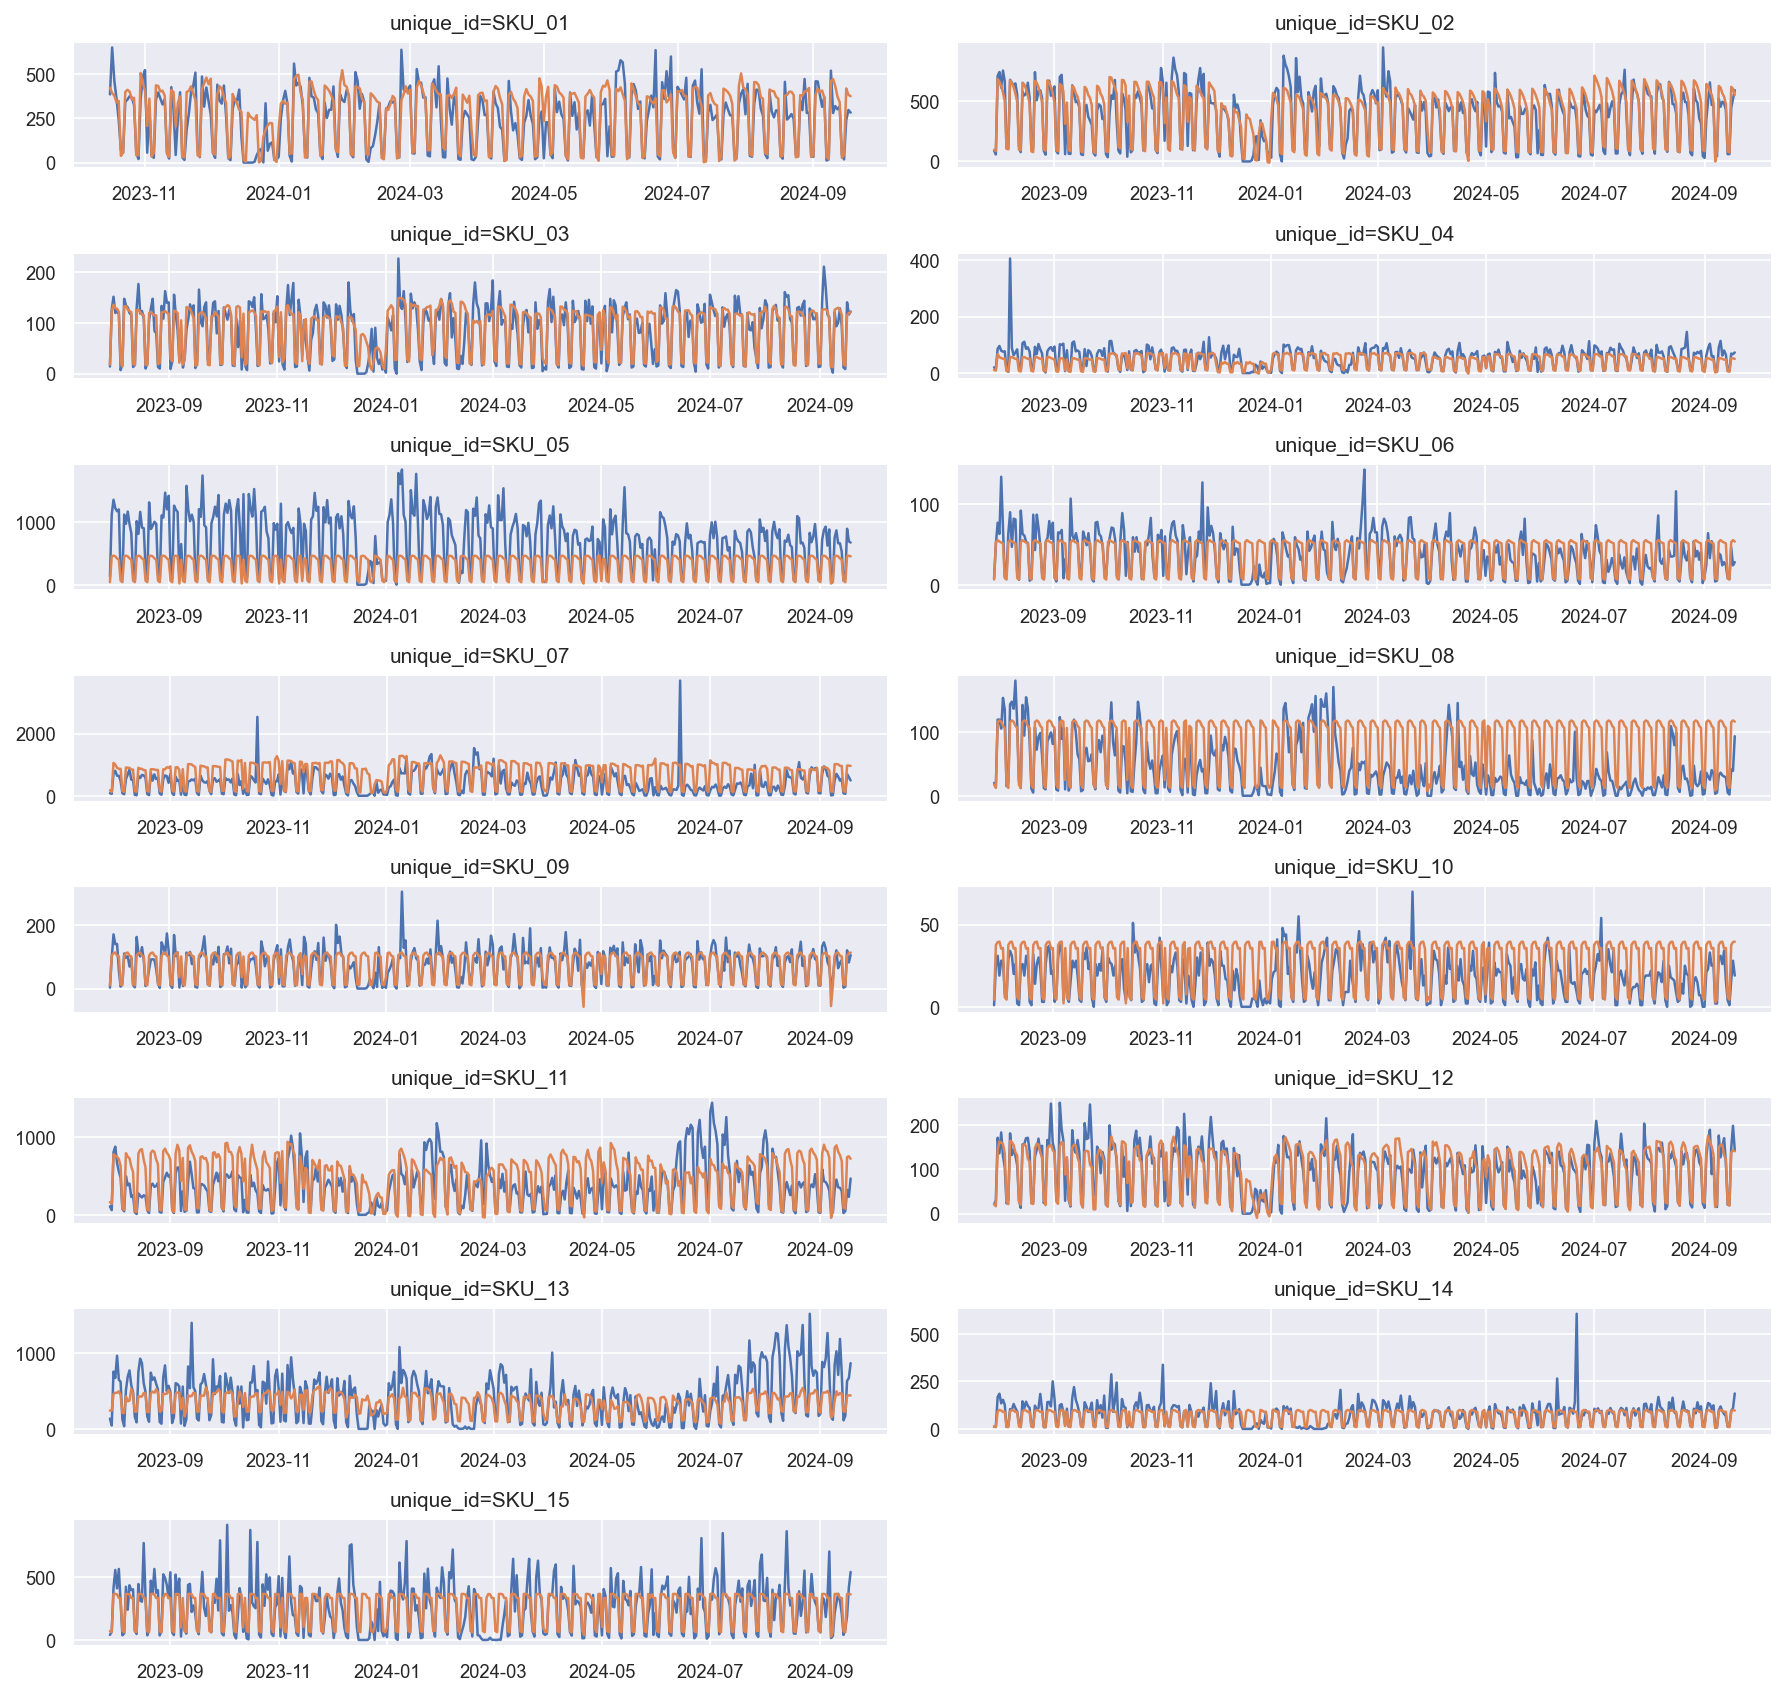

In [15]:
fig = plot_time_series(df=xgb_fcst, data_cols=['y', 'y_pred'])

In [17]:
rf_eval = Evaluation(xgb_fcst)
rf_eval.summary()
rf_eval.save_evaluation(EVAL_PATH, 'XGBoost [+HT]')
rf_eval.evaluation_df

,mae,mse,rmse,r2
SKU_01,71.34,9695.08,98.46,0.66
SKU_02,81.49,12692.83,112.66,0.76
SKU_03,18.47,672.44,25.93,0.76
SKU_04,16.46,764.86,27.66,0.47
SKU_05,385.49,241958.59,491.89,-0.13
SKU_06,13.52,370.89,19.26,0.47
SKU_07,351.76,204824.90,452.58,-0.43
SKU_08,45.28,3261.03,57.11,-0.94
SKU_09,20.96,954.01,30.89,0.64
SKU_10,10.84,194.76,13.96,-0.22


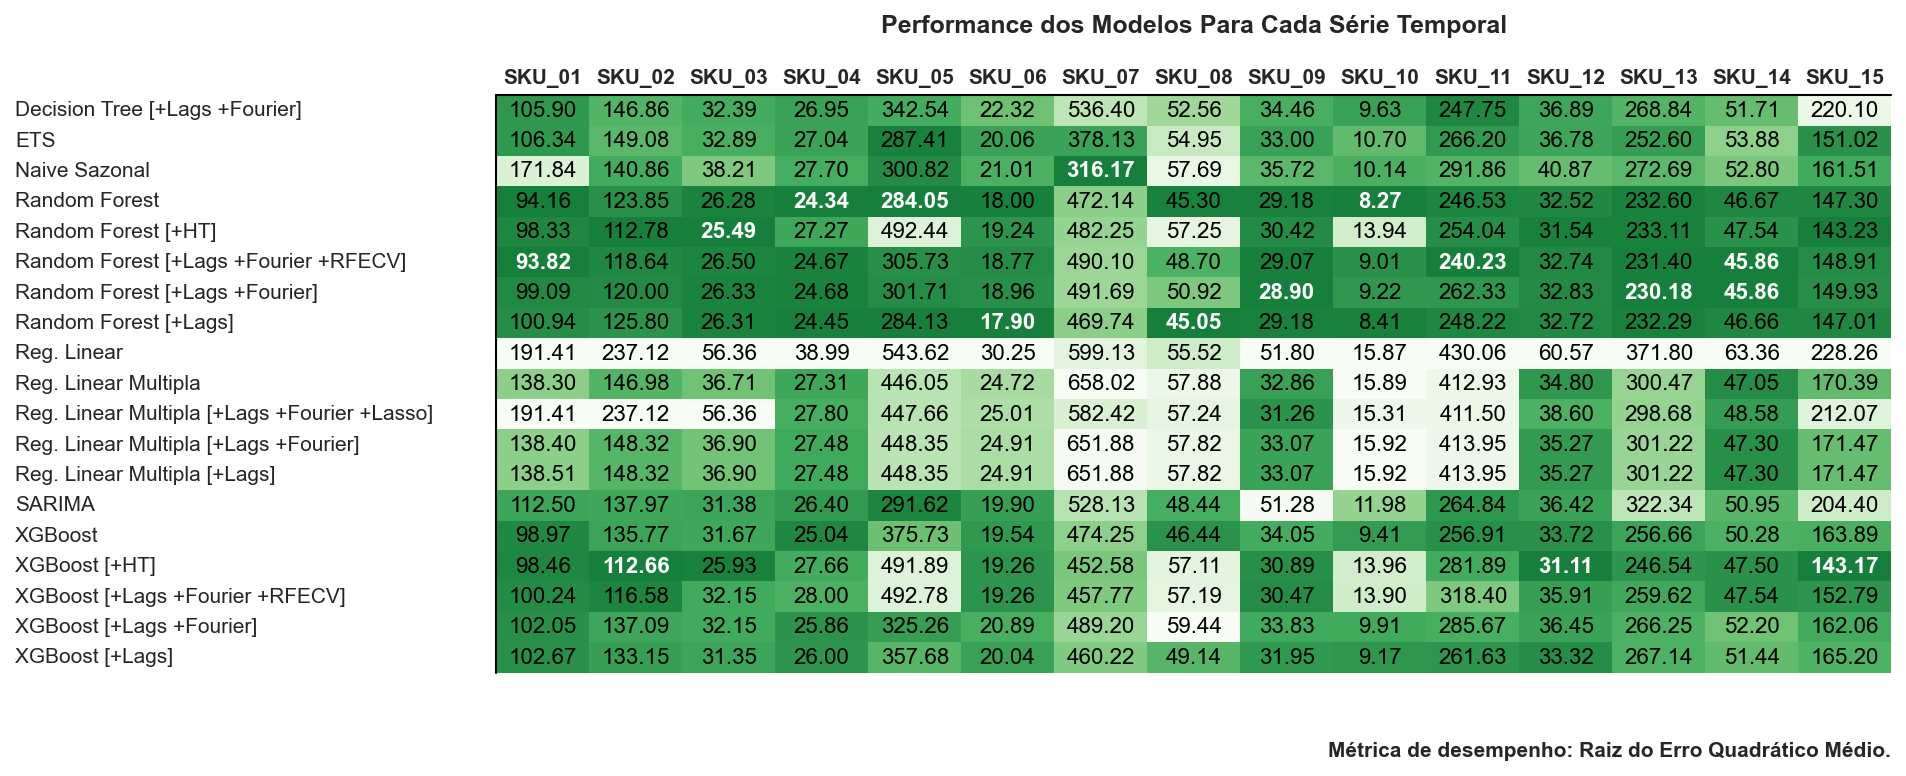

In [18]:
# comparação dos modelos
metrics = pd.read_csv(EVAL_PATH)
order = metrics['model'].sort_values().unique()
metrics = metrics.pivot_table('rmse','unique_id','model')[order]

fig = plot_metrics(metrics, figsize=(12, 5))

In [ ]:
# selecionar modelos que possuem melhor desempenho e rodar mais vezes e armazenas as médias
# não definir a semente aleatória
# armazenar desvpad dos resultados e identificar os modelos mais estáveis
